# Load random image and groundtruth (CITYSCAPES)

In [1]:
%matplotlib notebook
import numpy as np
from PIL import Image
import os
import random
import caffe

# init
caffe.set_device(0)
caffe.set_mode_gpu()

path2images = "/data02/bioinf/treml/cityscapes/leftImg8bit/train"
path2labels = "/data02/bioinf/treml/cityscapes/gtFine/train"


#{root}/{type}{video}/{split}/{city}/{city}_{seq:0>6}_{frame:0>6}_{type}{ext}


# take random place-folder
place = random.choice(os.listdir(path2images))
Iname = random.choice(os.listdir(os.path.join(path2images, place)))
Lname = '_'.join(Iname.split('_')[:3]) + '_gtFine_instanceTrainIds.png'
#print('Place:', place, 'file:', Iname)
path2im = os.path.join(path2images, place, Iname)
print('Image: ', Iname)
path2lab = os.path.join(path2labels, place, Lname)
print('Label: ', Lname)

# load image (RGB), switch to BGR, subtract mean, and make dims C x H x W for Caffe
im = Image.open(path2im)
in_ = np.array(im, dtype=np.float32)
in_ = in_[:,:,::-1]
in_ -= np.array((104.00698793,116.66876762,122.67891434))
in_ = in_.transpose((2,0,1))

# load groundtruth (32 bit signed integers (mode I))
gt = Image.open(path2lab)
#print('Label has mode', gt.mode)
gt = np.array(gt, dtype=np.uint8)
#print('Label has shape', gt.shape)
#print('Image has mode', im.mode)
#print('Image has shape', in_.shape)

# Cityscapes has fixed input sizes, e.g.:
#
# Image has shape (3, 1024, 2048)
# Label has shape (1, 1024, 2048, 4)

Image:  bochum_000000_004032_leftImg8bit.png
Label:  bochum_000000_004032_gtFine_instanceTrainIds.png


# Load PRE-TRAINED net to infer from

In [2]:
# use adapted cityscapes net with 19 classes
net = caffe.Net('city-fcn8s-atonce/deploy.prototxt', 
                          'city-fcn8s-atonce/logs/N=10_lr=1e-10/snapshot/train_iter_300.caffemodel',
                          caffe.TEST)

In [3]:
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
out = net.blobs['score'].data[0].argmax(axis=0)
print('MEAN: ', np.mean(out[:]))

MEAN:  3.59926223755


# Do the plotting

12 classes: [0, 1, 2, 4, 5, 8, 9, 10, 11, 12, 13, 15] or ['road', 'sidewalk', 'building', 'fence', 'pole', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'bus']
COLORMAP HAS 19 COLORS


<IPython.core.display.Javascript object>


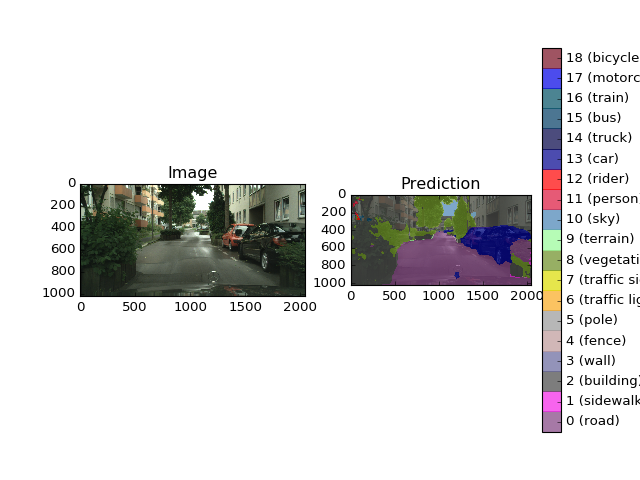

<IPython.core.display.Javascript object>


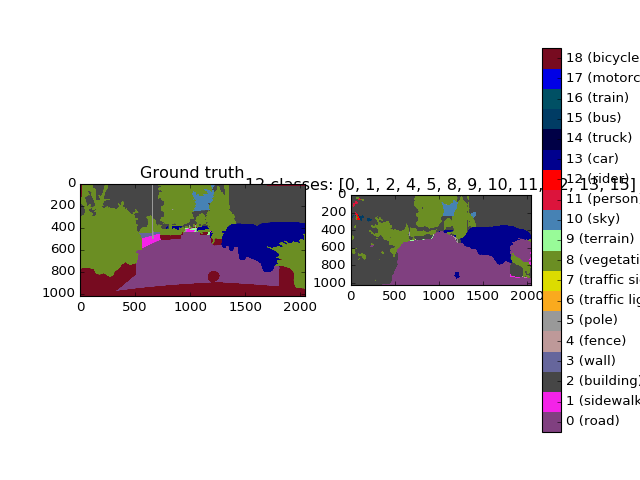

In [4]:
import infer_plots_CITY as infp
infp.printClassPredInfo(out)
infp.plot_inference_results(im, gt, out)